In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.signal import square
from scipy.signal import sawtooth
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Simulation

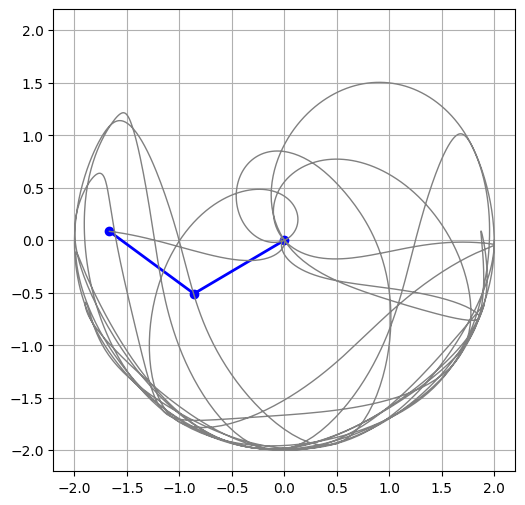

In [2]:

g = 9.81
L1 = 1.0
L2 = 1.0
m1 = 1.0
m2 = 1.0


def torque_input(t):
    freq = 0.25  # Hz
    amplitude = 1.0  # N.m
    return amplitude * square(2 * np.pi * freq * t)

def double_pendulum(t, y):
    theta1, omega1, theta2, omega2 = y
    delta = theta2 - theta1
    tau = torque_input(t)

    den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta)**2
    den2 = (L2 / L1) * den1

    domega1 = (
        m2 * L1 * omega1**2 * np.sin(delta) * np.cos(delta) +
        m2 * g * np.sin(theta2) * np.cos(delta) +
        m2 * L2 * omega2**2 * np.sin(delta) -
        (m1 + m2) * g * np.sin(theta1) +
        tau
    ) / den1

    domega2 = (
        -m2 * L2 * omega2**2 * np.sin(delta) * np.cos(delta) +
        (m1 + m2) * g * np.sin(theta1) * np.cos(delta) -
        (m1 + m2) * L1 * omega1**2 * np.sin(delta) -
        (m1 + m2) * g * np.sin(theta2)
    ) / den2

    return [omega1, domega1, omega2, domega2]


y0 = [np.pi / 2, 0, np.pi / 2, 0]
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 2000)


sol = solve_ivp(double_pendulum, t_span, y0, t_eval=t_eval, rtol=1e-8)
theta1, omega1, theta2, omega2 = sol.y[0], sol.y[1], sol.y[2], sol.y[3]

# Coordinates
x1 = L1 * np.sin(theta1)
y1 = -L1 * np.cos(theta1)
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)


fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(-2.2, 2.2)
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2, color='blue')
trace, = ax.plot([], [], '-', lw=1, color='gray')
history_x, history_y = [], []

def init():
    line.set_data([], [])
    trace.set_data([], [])
    return line, trace

def update(frame):
    thisx = [0, x1[frame], x2[frame]]
    thisy = [0, y1[frame], y2[frame]]
    line.set_data(thisx, thisy)

    history_x.append(x2[frame])
    history_y.append(y2[frame])
    trace.set_data(history_x, history_y)
    return line, trace

ani = animation.FuncAnimation(fig, update, frames=len(t_eval),
                              init_func=init, blit=True, interval=20)

HTML(ani.to_html5_video())



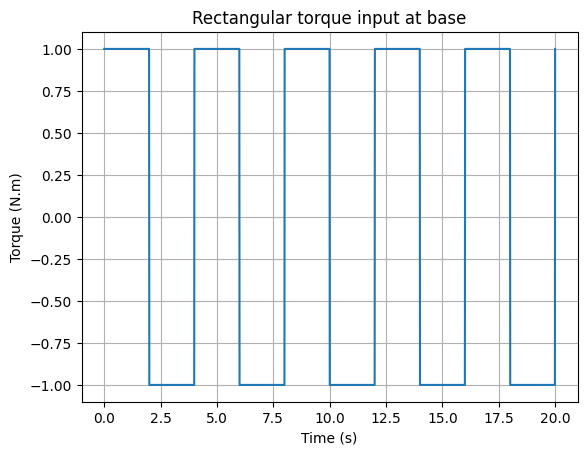

In [3]:
plt.figure()
torque_t = [torque_input(t) for t in t_eval]
plt.plot(t_eval, torque_t)
plt.title("Rectangular torque input at base")
plt.xlabel("Time (s)")
plt.ylabel("Torque (N.m)")
plt.grid()
plt.show()


# Data Preprocessing

In [9]:

X = np.column_stack((
    torque_t[1:],
    theta1[:-1], omega1[:-1],
    theta2[:-1], omega2[:-1]
))

Y = np.column_stack((
    theta1[1:], omega1[1:],
    theta2[1:], omega2[1:]
))

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]


scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
Y_train_scaled = scaler_Y.fit_transform(Y_train)

X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)


# MLP model training

In [10]:

X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_train_scaled, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test_scaled, dtype=torch.float32)

class MLP(nn.Module):
    def __init__(self, input_size=5, hidden_size=256, output_size=4):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x)


model = MLP()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)




Epoch [10/200], Loss: 0.959812
Epoch [20/200], Loss: 0.959090
Epoch [30/200], Loss: 0.964417
Epoch [40/200], Loss: 0.959746
Epoch [50/200], Loss: 0.958797
Epoch [60/200], Loss: 0.961268
Epoch [70/200], Loss: 0.959483
Epoch [80/200], Loss: 0.959095
Epoch [90/200], Loss: 0.958688
Epoch [100/200], Loss: 0.957925
Epoch [110/200], Loss: 0.957086
Epoch [120/200], Loss: 0.959761
Epoch [130/200], Loss: 0.959206
Epoch [140/200], Loss: 0.958826
Epoch [150/200], Loss: 0.958121
Epoch [160/200], Loss: 0.958085
Epoch [170/200], Loss: 0.959541
Epoch [180/200], Loss: 0.958466
Epoch [190/200], Loss: 0.958610
Epoch [200/200], Loss: 0.957558


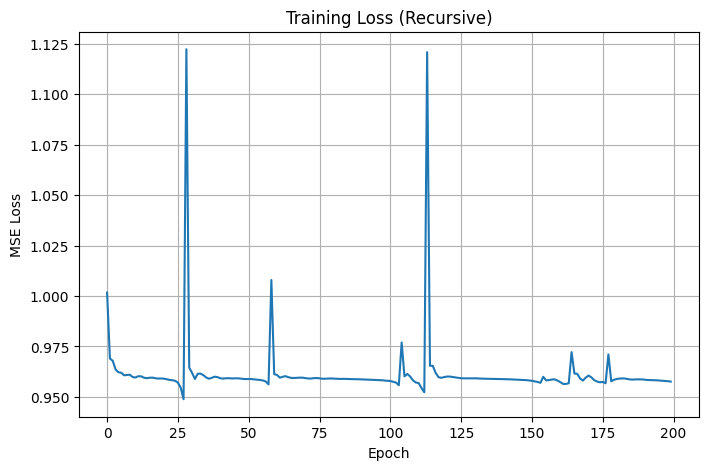

In [11]:
num_epochs = 200
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Initialize the first input (t=0)
    X_rec = X_train_scaled[0].copy().reshape(1, -1)

    preds_scaled = []

    for t in range(len(X_train_scaled)):
        X_rec_torch = torch.tensor(X_rec, dtype=torch.float32)

        Y_pred_scaled = model(X_rec_torch)
        preds_scaled.append(Y_pred_scaled)

        if t < len(X_train_scaled) - 1:
            next_torque = X_train_scaled[t + 1, 0].reshape(1, 1)
            Y_pred_np = Y_pred_scaled.detach().numpy()
            X_rec = np.concatenate([next_torque, Y_pred_np], axis=1)

    preds_scaled = torch.cat(preds_scaled, dim=0)

    Y_train_torch_seq = torch.tensor(Y_train_scaled, dtype=torch.float32)

    loss = criterion(preds_scaled, Y_train_torch_seq)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

plt.figure(figsize=(8,5))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss (Recursive)')
plt.grid(True)
plt.show()


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:

torch.save(model.state_dict(), '/content/drive/MyDrive/mlp_model.pth')

In [20]:
model = MLP()
model.load_state_dict(torch.load('/content/drive/MyDrive/mlp_model.pth'))
model.eval()

MLP(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
)

# test
as it was obvious, MLP has poor performance for modeling a dynamic system because of lack of memory in this kind of network architecture.

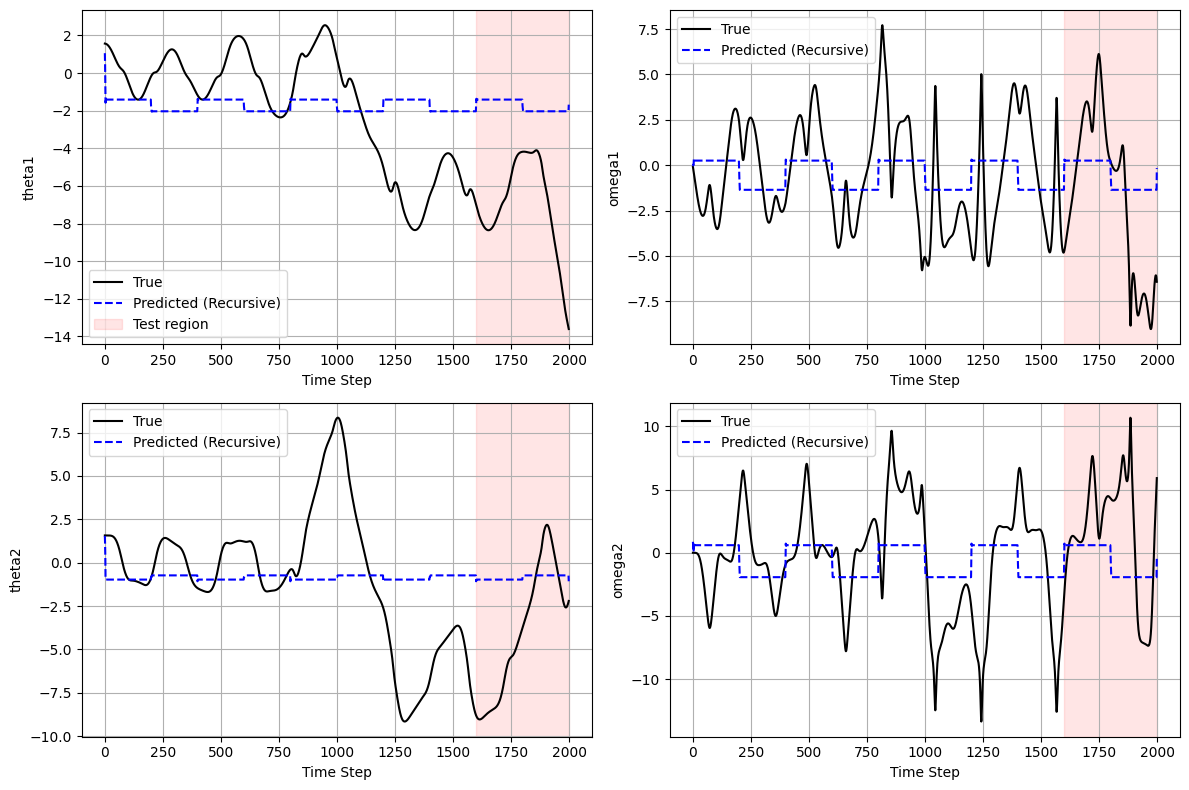

In [21]:


X_scaled_all = np.vstack([X_train_scaled, X_test_scaled])
Y_scaled_all = np.vstack([Y_train_scaled, Y_test_scaled])

X_rec = X_scaled_all[0].copy().reshape(1, -1)

Y_preds_scaled = []

model.eval()
with torch.no_grad():
    for t in range(len(X_scaled_all)):
        X_rec_torch = torch.tensor(X_rec, dtype=torch.float32)
        Y_pred_scaled = model(X_rec_torch).numpy().flatten()

        Y_preds_scaled.append(Y_pred_scaled)

        if t < len(X_scaled_all) - 1:
            next_torque = X_scaled_all[t + 1, 0].reshape(1, 1)
            next_input = np.concatenate([next_torque, Y_pred_scaled.reshape(1, -1)], axis=1)
            X_rec = next_input

Y_preds_scaled = np.array(Y_preds_scaled)

Y_preds = scaler_Y.inverse_transform(Y_preds_scaled)
Y_true = scaler_Y.inverse_transform(Y_scaled_all)

plt.figure(figsize=(12, 8))
labels = ['theta1', 'omega1', 'theta2', 'omega2']
time_all = np.arange(len(Y_true))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time_all, Y_true[:, i], label='True', color='black')
    plt.plot(time_all, Y_preds[:, i], '--', label='Predicted (Recursive)', color='blue')

    plt.axvspan(split_idx, len(Y_true)-1, color='red', alpha=0.1, label='Test region' if i == 0 else None)

    plt.xlabel('Time Step')
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# Sawtooth signal Test
here i tested the performance of this network in response to another typr of input torque. MLP had poor performance on train and test data so it is obvious that it will have the same poor performance here.

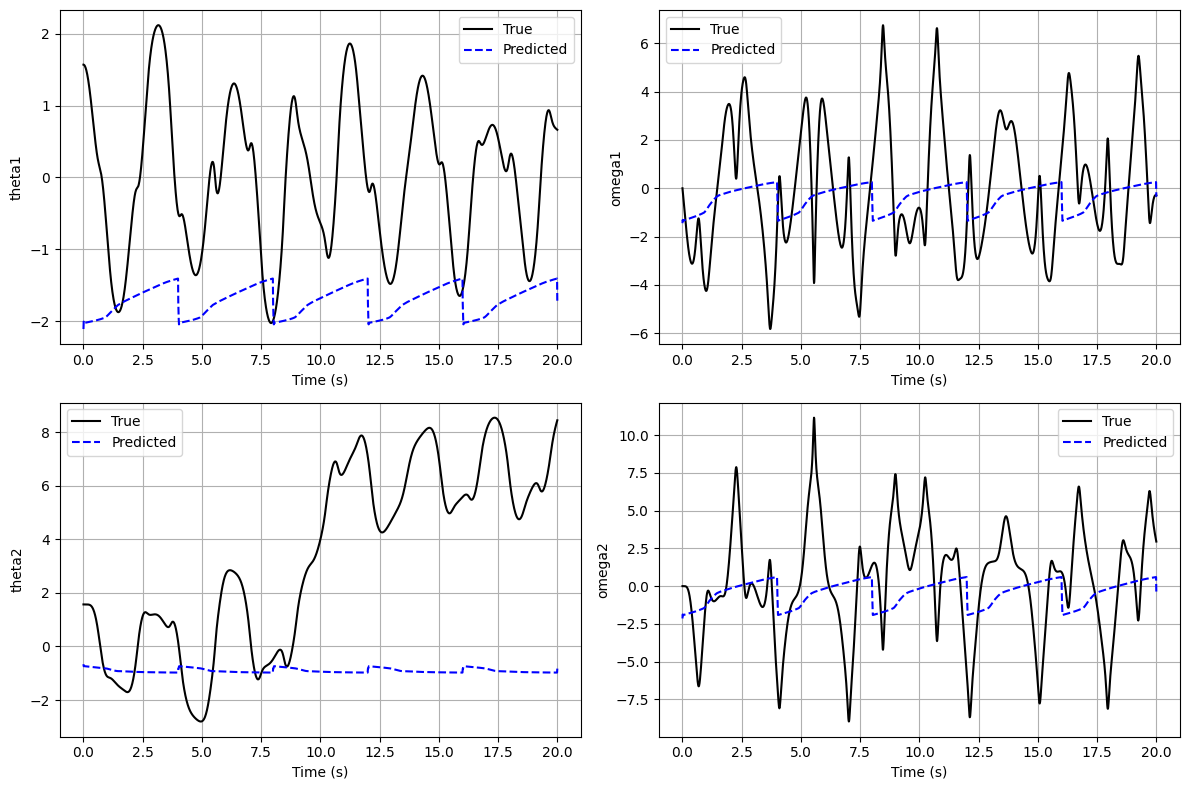

In [22]:


def torque_input_s(t):
    freq = 0.25  # Hz
    amplitude = 1.0  # N.m
    return amplitude * sawtooth(2 * np.pi * freq * t)

def double_pendulum(t, y):
    theta1, omega1, theta2, omega2 = y
    delta = theta2 - theta1
    tau = torque_input_s(t)

    den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta)**2
    den2 = (L2 / L1) * den1

    domega1 = (
        m2 * L1 * omega1**2 * np.sin(delta) * np.cos(delta) +
        m2 * g * np.sin(theta2) * np.cos(delta) +
        m2 * L2 * omega2**2 * np.sin(delta) -
        (m1 + m2) * g * np.sin(theta1) +
        tau
    ) / den1

    domega2 = (
        -m2 * L2 * omega2**2 * np.sin(delta) * np.cos(delta) +
        (m1 + m2) * g * np.sin(theta1) * np.cos(delta) -
        (m1 + m2) * L1 * omega1**2 * np.sin(delta) -
        (m1 + m2) * g * np.sin(theta2)
    ) / den2

    return [omega1, domega1, omega2, domega2]

y0 = [np.pi / 2, 0, np.pi / 2, 0]
t_span = (0, 20)
t_eval = np.linspace(*t_span, 2000)
sol = solve_ivp(double_pendulum, t_span, y0, t_eval=t_eval, rtol=1e-8)
theta1s, omega1s, theta2s, omega2s = sol.y
Y_true = np.column_stack([theta1s, omega1s, theta2s, omega2s])

torque_vals = torque_input_s(t_eval)

X_rec = np.concatenate([[[torque_vals[0]]], [y0]], axis=1)
X_rec = scaler_X.transform(X_rec)

Y_preds_scaled = []

model.eval()
with torch.no_grad():
    for i in range(len(t_eval)):
        X_rec_torch = torch.tensor(X_rec, dtype=torch.float32)
        Y_pred_scaled = model(X_rec_torch).numpy().flatten()
        Y_preds_scaled.append(Y_pred_scaled)

        if i < len(t_eval) - 1:
            next_torque = torque_vals[i + 1]
            next_state = scaler_Y.inverse_transform(Y_pred_scaled.reshape(1, -1)).flatten()
            next_input = np.concatenate([[next_torque], next_state]).reshape(1, -1)
            X_rec = scaler_X.transform(next_input)

Y_preds_scaled = np.array(Y_preds_scaled)
Y_preds = scaler_Y.inverse_transform(Y_preds_scaled)


plt.figure(figsize=(12, 8))
labels = ['theta1', 'omega1', 'theta2', 'omega2']

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(t_eval, Y_true[:, i], color='black', label='True')
    plt.plot(t_eval, Y_preds[:, i], '--', color='blue', label='Predicted')
    plt.xlabel('Time (s)')
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# CNN

In [25]:
class CNN(nn.Module):
    def __init__(self, input_channels=5, output_size=4, hidden_channels=64):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=hidden_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=hidden_channels, out_channels=output_size, kernel_size=1)
        )

    def forward(self, x):  # x: (batch, channels, seq_len=1)
        x = self.net(x)  # output shape: (batch, output_channels, 1)
        return x.squeeze(-1)  # → (batch, output_channels)

model = CNN()
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.MSELoss()

# Train

In [26]:
num_epochs = 200
train_losses = []

X_train_scaled = np.array(X_train_scaled)
Y_train_scaled = np.array(Y_train_scaled)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    X_rec = X_train_scaled[0].copy().reshape(1, -1)  # shape: (1, 5)
    preds_scaled = []

    for t in range(len(X_train_scaled)):
        # Reshape to CNN format: (batch=1, channels=5, seq_len=1)
        X_input = torch.tensor(X_rec.T.reshape(1, 5, 1), dtype=torch.float32)
        Y_pred = model(X_input)
        preds_scaled.append(Y_pred)

        if t < len(X_train_scaled) - 1:
            # Next torque
            next_torque = X_train_scaled[t + 1, 0].reshape(1, 1)
            # Current predicted state
            Y_pred_np = Y_pred.detach().numpy()
            X_rec = np.concatenate([next_torque, Y_pred_np], axis=1)

    preds_scaled = torch.cat(preds_scaled, dim=0)
    Y_true_torch = torch.tensor(Y_train_scaled, dtype=torch.float32)

    loss = criterion(preds_scaled, Y_true_torch)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

Epoch [10/200], Loss: 0.960152
Epoch [20/200], Loss: 0.959730
Epoch [30/200], Loss: 0.959313
Epoch [40/200], Loss: 0.958973
Epoch [50/200], Loss: 0.958629
Epoch [60/200], Loss: 0.958151
Epoch [70/200], Loss: 0.957143
Epoch [80/200], Loss: 0.948277
Epoch [90/200], Loss: 0.961950
Epoch [100/200], Loss: 0.957559
Epoch [110/200], Loss: 0.957095
Epoch [120/200], Loss: 0.944539
Epoch [130/200], Loss: 1.059911
Epoch [140/200], Loss: 0.956804
Epoch [150/200], Loss: 0.956318
Epoch [160/200], Loss: 0.954202
Epoch [170/200], Loss: 0.983284
Epoch [180/200], Loss: 0.955258
Epoch [190/200], Loss: 0.954607
Epoch [200/200], Loss: 0.977361


# Test

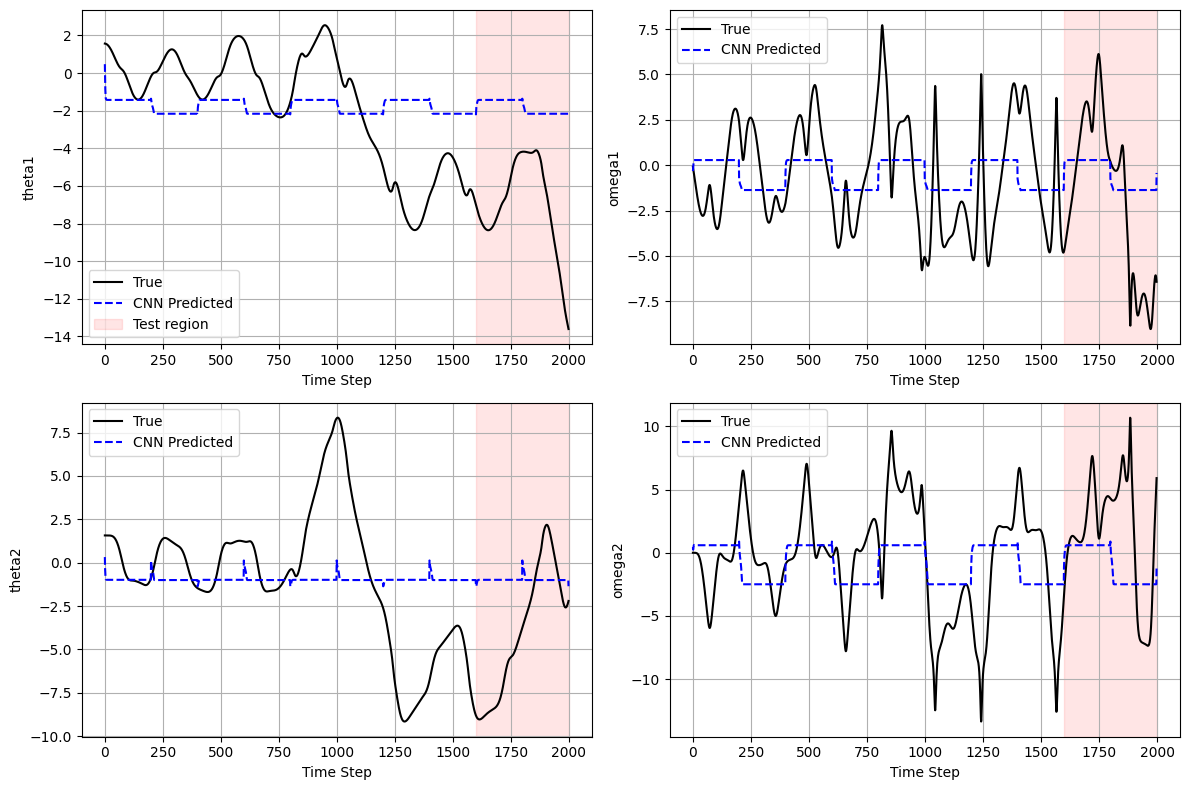

In [27]:
X_scaled_all = np.vstack([X_train_scaled, X_test_scaled])
Y_scaled_all = np.vstack([Y_train_scaled, Y_test_scaled])

model.eval()
Y_preds_scaled = []
X_rec = X_scaled_all[0].copy().reshape(1, -1)

with torch.no_grad():
    for t in range(len(X_scaled_all)):
        X_input = torch.tensor(X_rec.T.reshape(1, 5, 1), dtype=torch.float32)
        Y_pred = model(X_input).numpy().flatten()
        Y_preds_scaled.append(Y_pred)

        if t < len(X_scaled_all) - 1:
            next_torque = X_scaled_all[t + 1, 0].reshape(1, 1)
            X_rec = np.concatenate([next_torque, Y_pred.reshape(1, -1)], axis=1)

Y_preds_scaled = np.array(Y_preds_scaled)
Y_preds = scaler_Y.inverse_transform(Y_preds_scaled)
Y_true = scaler_Y.inverse_transform(Y_scaled_all)

plt.figure(figsize=(12, 8))
labels = ['theta1', 'omega1', 'theta2', 'omega2']
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(Y_true[:, i], label='True', color='black')
    plt.plot(Y_preds[:, i], '--', label='CNN Predicted', color='blue')
    plt.axvspan(split_idx, len(Y_true), color='red', alpha=0.1, label='Test region' if i == 0 else None)
    plt.xlabel("Time Step")
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
